In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Read in
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/'
byState = pd.read_csv(url+'us-states.csv', index_col='state', parse_dates=['date'])
byCnty = pd.read_csv(url+'us-counties.csv', index_col='state', parse_dates=['date'])

In [3]:
s = 'Florida'
c = 'Miami-Dade'

In [4]:
state = byState.loc[s]
county = byCnty.loc[s]
county = county.reset_index().set_index('county')
county = county.loc[c]

In [5]:
# Add new cases
state = state.reset_index().set_index('date')
county = county.reset_index().set_index('date')
state['newCases'] = state.cases.diff()
county['newCases'] = county.cases.diff()

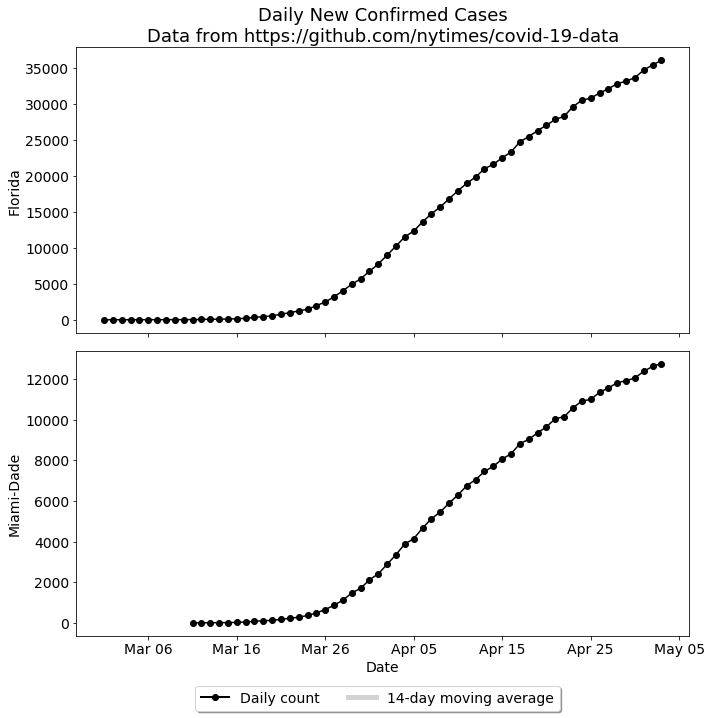

In [10]:
# Make plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax1.plot(state.cases, '-o', label='Daily count', color='black')
#ax1.plot(state['newCases'].rolling(14).mean(), label='14-day moving average', color='lightgrey', linewidth=5)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylabel(s, fontsize=14)
ax1.set_title('Daily New Confirmed Cases\nData from https://github.com/nytimes/covid-19-data', fontsize=18)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax2.plot(county.cases, '-o', label='Daily count', color='black')
#ax2.plot(county['newCases'].rolling(14).mean(), label='14-day moving average', color='lightgrey', linewidth=5)
ax2.set_xlabel('Date', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel(c, fontsize=14)
ax2.legend(loc='best', fontsize=14)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

custom_lines = [plt.Line2D([0],[0], linestyle='solid', lw=2,
                           color='black', marker='o'),
                plt.Line2D([0],[0], linestyle='solid', lw=5,
                           color='lightgrey')]
ax2.legend(custom_lines, ['Daily count', '14-day moving average'],
           ncol=2, fontsize=14, bbox_to_anchor=(0.8, -0.15),
           edgecolor='lightgrey', fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

In [22]:
from us_state_abbrev import us_state_abbrev as abbr

In [23]:
regions = [('Florida', 'Miami-Dade'),
           ('Delaware', 'Sussex'),
           ('Connecticut', 'Litchfield'),
           ('Massachusetts', 'Plymouth'),
           ('Michigan', 'Midland')]

In [26]:
for s, c in regions:
    print('{} County in {} ({})'.format(c, s, abbr[s]))

Miami-Dade County in Florida (FL)
Sussex County in Delaware (DE)
Litchfield County in Connecticut (CT)
Plymouth County in Massachusetts (MA)
Midland County in Michigan (MI)
